In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clean_img = '/content/drive/MyDrive/Clean_image_gray'

In [ ]:
import os
i = os.listdir(clean_img)
len(i)

51

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
clean_frames = []
for file in tqdm(sorted(os.listdir(clean_img))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(clean_img + '/' + file, target_size= (100,100))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    clean_frames.append(image)

clean_frames = np.array(clean_frames)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
print(clean_frames.shape)   

(51, 100, 100, 3)


In [ ]:
bad_frames = '/content/drive/MyDrive/Noisy_image_gray'

In [ ]:
noisy_frames = []

for file in tqdm(sorted(os.listdir(bad_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    img = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(100,100))
    image = tf.keras.preprocessing.image.img_to_array(img).astype('float32') / 255
    noisy_frames.append(image)
    image = np.uint8(image)

noisy_frames = np.array(noisy_frames)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
print(noisy_frames.shape)

(51, 100, 100, 3)


In [ ]:
noisy_train = noisy_frames[0:round(len(noisy_frames)*0.8)]
noisy_test = noisy_frames[round(len(noisy_frames)*0.8):]

clean_train = clean_frames[0:round(len(clean_frames)*0.8)]
clean_test = clean_frames[round(len(clean_frames)*0.8):]

In [ ]:
print(noisy_test.shape)

(10, 100, 100, 3)


In [ ]:
import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import pickle
import numpy as np

In [ ]:
input = Input(shape=(100,100,3))
x = Conv2D(64, (3, 3), padding='same')(input)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
output = Activation('tanh')(x)

In [ ]:
model = Model(input, output)

model.compile(optimizer='adam',loss='mean_squared_error',metrics=["acc"])

In [ ]:
es_cb = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')
chkpt = "/content/drive/MyDrive/model"
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
history = model.fit(noisy_train, clean_train,
                    batch_size=2,
                    epochs=100,
                    verbose=1,
                    validation_data=(noisy_test, clean_test),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/100
21/21 [==============================] - 44s 2s/step - loss: 0.1117 - acc: 0.2823 - val_loss: 0.0598 - val_acc: 1.4000e-04

Epoch 00001: val_loss improved from inf to 0.05984, saving model to /content/drive/MyDrive/model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets
Epoch 2/100
21/21 [==============================] - 42s 2s/step - loss: 0.0248 - acc: 0.1881 - val_loss: 0.0740 - val_acc: 0.0021

Epoch 00002: val_loss did not improve from 0.05984
Epoch 3/100
21/21 [==============================] - 42s 2s/step - loss: 0.0215 - acc: 0.3010 - val_loss: 0.0582 - val_acc: 0.0835

Epoch 00003: val_loss improved from 0.05984 to 0.05821, saving model to /content/drive/MyDrive/model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets
Epoch 4/100
21/21 [==============================] - 42s 2s/step - loss: 0.0199 - acc: 0.3123 - val_loss: 0.0584 - val_acc: 0.2607

Epoch 00004: val_loss did not improve from 0.05821
Epoch 5/100
21/21 [=======

In [ ]:
print("final loss",history.history['loss'][-1])
print("final accuracy",history.history['acc'][-1])
print("final validation loss",history.history['val_loss'][-1])
print("final validation accuracy",history.history['val_acc'][-1])

final loss 0.005677057895809412
final accuracy 0.3135439157485962
final validation loss 0.011342713609337807
final validation accuracy 0.321150004863739


In [ ]:
t = model.predict(noisy_test)

In [ ]:
import random
image = np.random.randint(0, len(noisy_test))

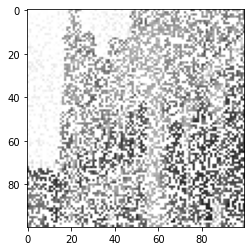

In [ ]:
plt.imshow(noisy_test[image])
plt.show()

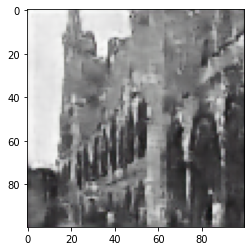

In [ ]:
plt.imshow(t[image])
plt.show()

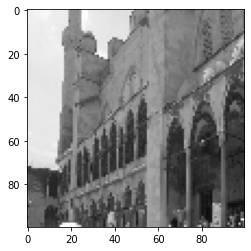

In [ ]:
plt.imshow(clean_test[image])
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = t
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(clean_test, noisy_test, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=clean_test.shape[0]
psnr_prediction_mean/=clean_test.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 7.813395419216316
Predicted average gt-predicted PSNR -> 19.60074094093252


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = t
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(clean_test, noisy_test, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=clean_test.shape[0]
ssim_prediction_mean/=clean_test.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.19004862808039308
Predicted average gt-predicted SSIM -> 0.6361164441010777


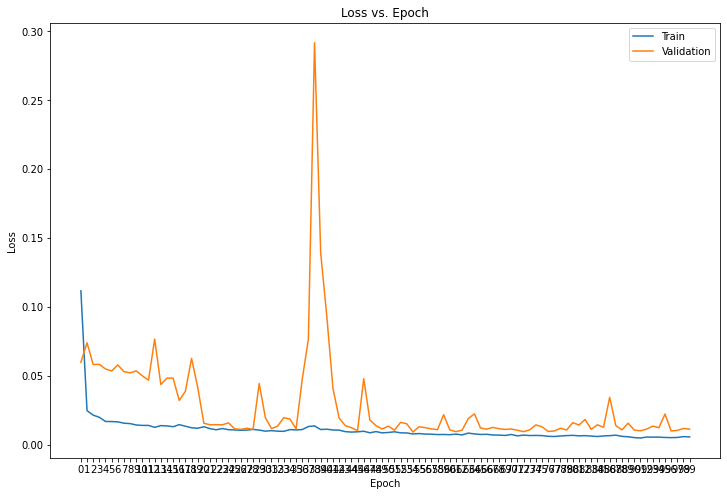

In [ ]:
plt.figure(figsize=(12,8))  #loss function graph 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=history.epoch, labels=history.epoch)
plt.show()

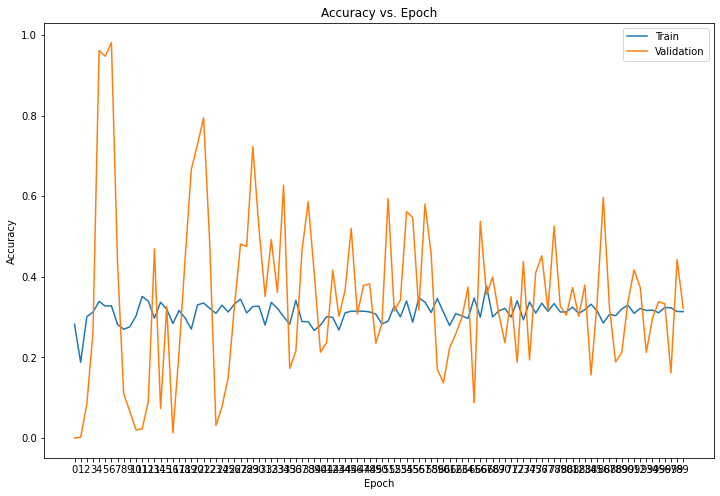

In [ ]:
plt.figure(figsize=(12,8))    #accuracy graph 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Validation'])
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=history.epoch, labels=history.epoch)
plt.show()